In [3]:

npath = "/home/shubham/Projects/Anomaly/data/"

x = np.fromfile(npath+"x_b2.txt", sep=' ')
y = np.fromfile(npath+"y_b2.txt", sep=' ')

# data matrix
royal_b2 = np.array([x,y]).T


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [103]:
plt.style.use('~/Projects/Anomaly/.styles/pres.mplstyle')

In [96]:
plt.style.use('default')

Text(0, 0.5, '$x_2$')

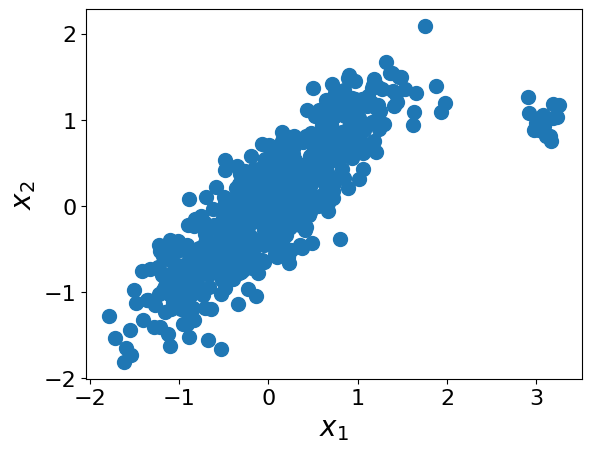

In [47]:
x = royal_b2
plt.scatter(*x.T)#,c= np.ones(len(x)))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")


In [9]:
import sys
sys.path.insert(0,"/home/shubham/Projects/Anomaly/src/unsup")
# import datgen2 as db
import utils


In [10]:
cm = utils.co_variance(x)

In [11]:
V,S,U = np.linalg.svd(cm,full_matrices=False)

In [54]:
U

array([[-0.77263341, -0.63485243],
       [-0.63485243,  0.77263341]])

In [12]:
def colorgen(colora="rgbk"):
    for i in colora:
        yield i
cgen = colorgen("rbgk")
def plotVec(V,ax,namer="None",a=0,c='r'):
    V += a
#     c = next(cgen)
    ax.plot([a,V[0,0]],[a,V[0,1]],'-'+c,linewidth=3)
    ax.plot([a,V[1,0]],[a,V[1,1]],'--'+c,linewidth=2,label=namer)

Text(0, 0.5, '$x_2$')

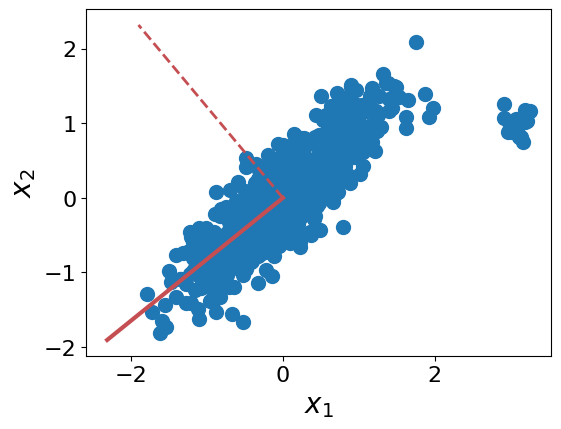

In [13]:
fig,ax = plt.subplots(figsize=(6,4.5))
ax.plot(*x.T, 'o')

plotVec(3*U,ax,"Variance")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

## Low dim

In [45]:
pc = U[0]
## Picked first principle vector

xr = np.dot(x,pc)   ## reduced
xp = np.outer(xr,pc) ## Predicted

Text(0, 0.5, '$x_2$')

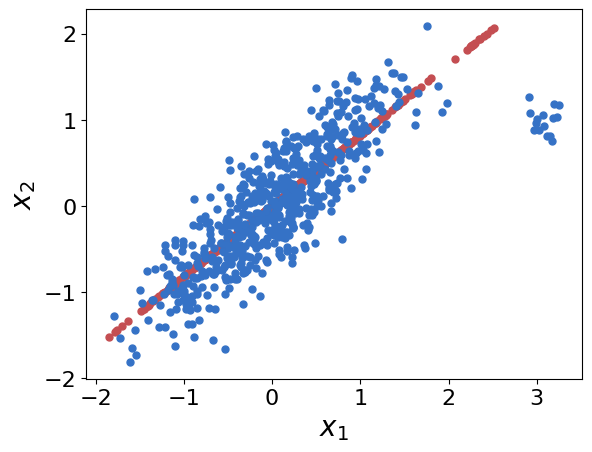

In [55]:
plt.plot(*xp.T,'.r')
plt.plot(*x.T,'.b')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

In [56]:
# plt.scatter(*xp.T, 'r.')


## Make up a source term

In [69]:
x1,y1 = x.T
z1 = np.exp(0.62*(3.1*x1-2.08*y1))

In [17]:
n = 610

Text(0, 0.5, '$f(x_1,x_2)$')

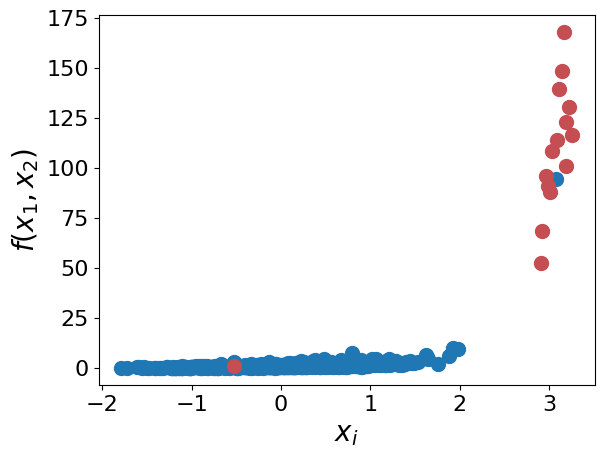

In [18]:
plt.plot(x1[:n],z1[:n],'o')
plt.plot(x1[n:],z1[n:],'ro')
plt.xlabel(r"$x_i$")
plt.ylabel(r"$f(x_1,x_2)$")


In [29]:
pc1 = U[0]
xr = np.dot(x,pc1)

In [41]:
xp = np.outer(xr,pc1)

**Recaculate source term from the predicted data: xp**

In [58]:
from sklearn.ensemble import RandomForestRegressor

## Random Forest (or Bootstrap Aggregation) should perform better that
## General additive model, (Mars for eg), Ref: Tibishirani, ESL page 322

In [70]:
model = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model.fit(xp,z1)  ### should be zp? Check 1#

RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)

In [71]:
zp = model.predict(xp)


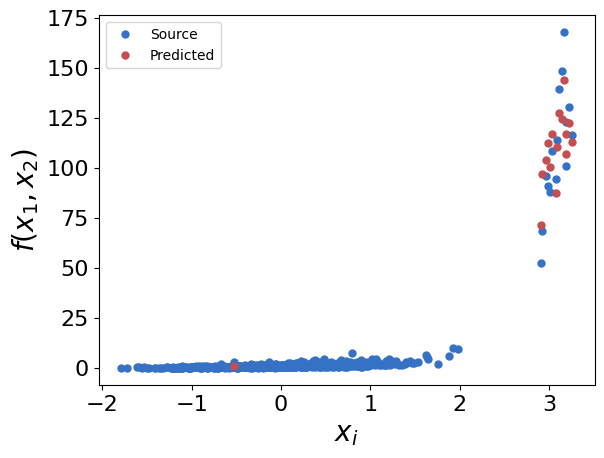

In [75]:
plt.plot(x1,z1,"b.",label="Source")
plt.plot(x1[n:],zp[n:],"r.",label="Predicted")
plt.xlabel(r"$x_i$")
plt.ylabel(r"$f(x_1,x_2)$")

plt.legend()

In [64]:
print("MSE is ",np.mean(np.abs(zp-z1)))

MSE is  1.3000970898601076


## Combinator

In [76]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
import os,sys
# sys.addaudithook
sys.path.insert(0,"/home/shubham/Projects/Anomaly/src/unsup")

import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [77]:
from utils import co_kurtosis,co_variance

In [78]:
modeldict = {
    'linear' : LinearRegression(),
    'svm' : SVR(),
    'forest': RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100),
    'knn' : KNeighborsRegressor(),
    'neural' : MLPRegressor()

}

In [79]:
def encode(x,method=co_variance):
    cm = method(x)
    V,S,U = np.linalg.svd(cm,full_matrices=False)
    pc = U[0] ### U[:1] num of vectors to chose
    xr = np.dot(x,pc)
    xe = np.outer(xr,pc)
    return xe ## encoded set

def decode(z,xp,model):
    model.fit(xp,z)
    zp = model.predict(xp)
    return zp


In [80]:
def mse(a,ap):
    return np.mean((a-ap)**2)

def tse(x,y):
    _conv = lambda x : np.array(x).T    
    x = _conv(x)
    y = _conv(y)
    return np.linalg.norm(x-y,ord=1,axis=1).sum()

mse = lambda a,ap: np.mean(np.abs(a-ap))

In [81]:
# x1,y1 = x.T
# z1 = np.exp(-0.62*(3.1*x1+1.08*y1))
dat = {'x':x1,'y':y1,'s':z1}

In [101]:
# result.setdefault(?)

In [84]:
pcdict = {'variance':co_variance,
         'kurtosis':co_kurtosis}
def comma(verbose=True,fi='x',si='s',enc=co_variance,dec=modeldict['linear']):
    xa = dat[fi]
    ya = dat[si]
    xen = encode(x,method=enc)
    xp = decode(xa,xen,model=dec)
    yp = decode(ya,xen,model=dec)

    if verbose:
        plt.plot(xa,ya,".",label="Original")
        plt.plot(xp,yp,"r.",label="Predicted")
        plt.xlabel(fi)
        plt.ylabel(si)
        plt.title(str(dec)[:16])
        plt.legend()
        plt.show()
    e1,e2 = mse(x1,xp),mse(y1,yp)
    e3 = tse([x1,y1],[xp,yp])
    
    if verbose:
        print(f""" method {enc},
        Reconstruction
        x error {e1} 
        y error {e2}
        total err {e3}
        """)
    return e1,e2,e3
    
interact(comma,verbose=[True,False],fi=['x','y'],si=['y','s'],enc=pcdict,dec=modeldict)

interactive(children=(Dropdown(description='verbose', options=(True, False), value=True), Dropdown(description…

<function __main__.comma(verbose=True, fi='x', si='s', enc=<function co_variance at 0x7f7d408dbd30>, dec=LinearRegression())>

In [85]:
results = {}
for k,v in pcdict.items():
    results[k] = {}
    for n,m in modeldict.items():
        e1,e2,e3 = comma(enc=v,dec=m,verbose=False)
        results[k][n] = [e1,e2,e3]
    
        
        

/home/shubham/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shubham/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [86]:
import pandas as pd


In [87]:
pd.DataFrame(results)

,variance,kurtosis
linear,"[0.15768770768506435, 6.353946338906639, 4069....","[0.04482506424164107, 7.291479594935096, 4585...."
svm,"[0.13299308137180885, 1.4607932688276861, 996....","[0.040214175694771384, 1.5996832440843978, 102..."
forest,"[0.05908149885488015, 3.9462537629479617, 2503...","[0.01693444141724807, 3.8576718666594285, 2421..."
knn,"[0.12161956902080001, 3.9965024272201175, 2573...","[0.03487223579519999, 3.9050915974808924, 2462..."
neural,"[0.14945271089437634, 4.490406613159319, 2899....","[0.0577163796102609, 4.271299255294701, 2705.6..."


In [88]:
errs = []
for i in range(3):
    errs.append({})
    for k,v in results.items():
        errs[i][k] = {}
        for m,eri in v.items():
            errs[i][k][m] = eri[i]
# results

In [98]:
plt.

AttributeError: module 'matplotlib.pyplot' has no attribute 'params'

Text(0.5, 1.0, 'Species reconstruction error')

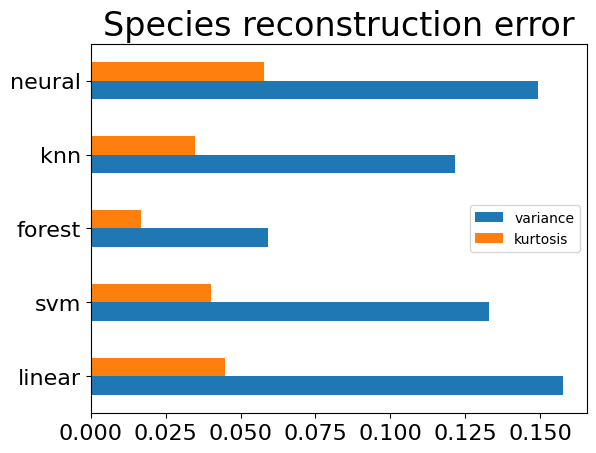

In [90]:
df1 = pd.DataFrame(errs[0])


df1.plot.barh()#(kind='bar')
plt.title("Species reconstruction error")

In [61]:
x = np.random.rand(4,2)
x

array([[0.04808808, 0.31537984],
       [0.48217065, 0.00739142],
       [0.27358622, 0.34791171],
       [0.95572047, 0.53159822]])

In [68]:
import pandas as pd
df = pd.DataFrame(x)
df.index = ["First","second","Thired","Finiss"]
df

,0,1
First,0.048088,0.315380
second,0.482171,0.007391
Thired,0.273586,0.347912
Finiss,0.955720,0.531598


In [ ]:
plt.

Text(0, 0.5, 'Reconstruction Method')

<Figure size 300x200 with 0 Axes>

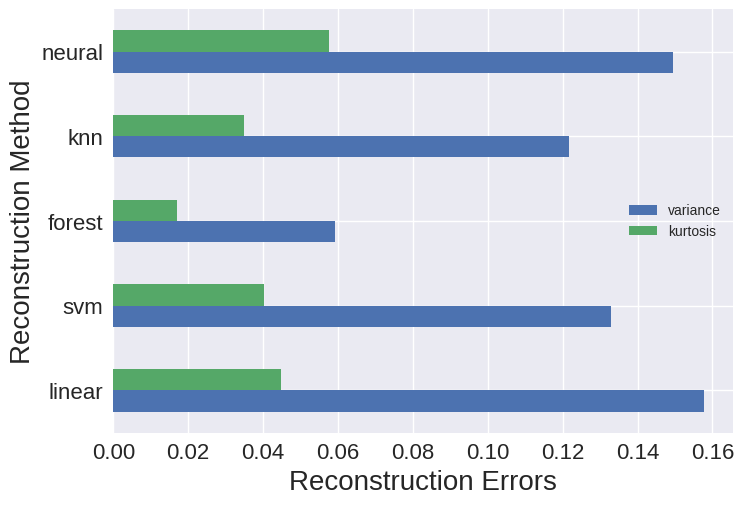

In [104]:
plt.figure(figsize=(3,2))
df1.plot.barh()
plt.xlabel("Reconstruction Errors")
plt.ylabel("Reconstruction Method")


In [ ]:
Original --------->  LowDim ======> Reconstruction

In [ ]:
Chem species xi --------> eta_i (trim_few pcs) ========>

In [ ]:
------> is Variance/Kurtosis

In [105]:
new = {"data":0,
      "fifty": 50,
      "Four":4}
for k,v in new.items():
    print(k,v)

data 0
fifty 50
Four 4
